# **Seattle Terry Stop Data Analysis**

##### Author: Spencer Hadel
***
### Overview

Recent tensions in the United States have led to a mistrust of police forces across the country, particularly due to the increasing strength of movements such as Black Lives Matter, and increased cultural attention to the racial and ethnic disparity in many facets of life. There is increasing focus on the scope of what police officer's are legally able to do, and whether they use this right fairly.

One such disparity has been observed in Terry Stops (also known as 'stop-and-frisks'), when a police officer uses theur right to legally temporarily detain a person based on 'reasonable suspsicion' that the person may be involved in criminal activity. The officer has the right to physically 'frisk' the subject, and take whatever action they feel is necessary properly handle the situation.

The newly elected mayor of Seattle campaigned on a platform of police reform, and has hired our agency to analyze, test, and interpret the current Seattle police department's Terry Stop data, so that their selected Chief of Police can make meaningful changes to the system as it stands.

### Data
This analysis utilizes about 52,000 data entries of Seattly Terry Stops ([from data.seattle.gov](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8)), in the file [Terry_Stops.csv](./data/Terry_Stops.csv). This data has been collected from 2015 until the present. A deeper explanation of this dataset and how it was cleaned can be found in the [First Notebook](./nb_1-terry_data_cleaning_analysis.ipynb).


***

# Part 3: Target and Feature Selection

So far, we have only run classifaction models on one set of features seeking to find one target variable. Going forward, we will test a few different arrangements of features and targets.

In [1]:
#get data
from imports import *
df = pd.read_csv('data/cleaned_df.csv')

#get score_df from previous notebook
%store -r score_df

#create cummy variables from categorical data
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.columns = dummies_df.columns.str.replace(' ','_')
#dummies_df.info()

There are a large number of potential features in this dataset, as well as 3 potential targets: Arrested, Legal_Action_Taken, and Physical_Arrest. In the [previous notebook](./terry_models.ipynb) we only attempted to find Physical Arrests using all the data that existed.

The first thing we do is see if there are better results with each of our other target variables, using Machine Learning Pipelines to streamline the workflow.

We will once again test our data with and without SMOTE since the change in target variables has changed how imbalanced the data is (in this case, it is LESS imbalanced).

In [2]:
#initialize classifiers
clf_forest = RandomForestClassifier(random_state=42)
clf_logreg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
clf_xgb = XGBClassifier(random_state=42)

#parameters for each classifier
logreg_param = {}
logreg_param['classifier__C'] = np.logspace(-2, 2, 10)
logreg_param['classifier__penalty'] = ['l1', 'l2']
logreg_param['classifier'] = [clf_logreg]


forest_param = {}
forest_param['classifier__n_estimators'] = [10,100,1000]
forest_param['classifier__max_depth'] = [None, 3, 4, 10]
forest_param['classifier__max_features'] = [2, 5, 10],
forest_param['classifier'] = [clf_forest]

xgb_param = {}
xgb_param['classifier__n_estimators'] = [10,100,1000]
xgb_param['classifier__learning_rate'] = [0.001, 0.01, 0.1]
xgb_param['classifier__subsample'] =  [0.7]
xgb_param['classifier__max_depth'] = [9]
xgb_param['classifier'] = [clf_xgb]

In [3]:
#create pipelines (SMOTE and non SMOTE)
pipeline = imbpipeline([('classifier', LogisticRegression())])

smote_pipeline = imbpipeline([('sm', SMOTE(random_state = 42)),('classifier', LogisticRegression())])

### Target: Arrested (Without Synthetic Data)

In [4]:
# remove other targets
dummies_df.drop(['Physical_Arrest', 'Legal_Action_Taken'], axis=1, inplace=True)

#prepare data
X= dummies_df.drop('Arrested', axis=1)
y = dummies_df['Arrested']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# new negative and positive description for visualizations and scoring
neg = 'Not Arrested'
pos = 'Arrested'

#use params established earlier
params = [logreg_param, forest_param, xgb_param]

#create and fit data using GridSearch and pipeline
arrested_cv = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=True, scoring='f1')
arrested_cv.fit(X_train, y_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            random_state=42,
                                                            solver='liblinear')],
                          'classifier__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.0...
                                                       n_estimators=1000,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
                                                       scale_pos_weight=None,
                                                       subsample=0.7,
                                                       tree_method=None,
                                                       validate_parameters=None,
                                                       verbosity=None)],
                          'classifier__learning_rate': [0.001, 0.01, 0.1],
                          'classifier__max_depth': [9],
                          'classifier__n_estimators': [10, 100, 1000],
                          'classifier__subsample': [0.7]}],
             scoring='f1', verbose=True)

In [5]:
#best parameters as decided by gridsearch
arrested_cv.best_params_

# {'classifier': XGBClassifier()
#  'classifier__learning_rate': 0.1,
#  'classifier__max_depth': 9,
#  'classifier__n_estimators': 1000,
#  'classifier__subsample': 0.7}

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=9,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=1000, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None),
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 1000,
 'classifier__subsample': 0.7}

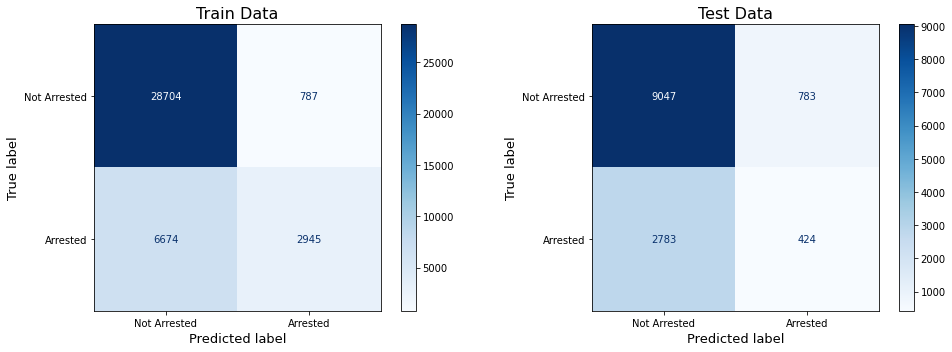

Train Data:                                 Test Data:
Accuracy:  0.8092303758629507               Accuracy:  0.7264708138375393
Recall:    0.30616488200436637              Recall:    0.1322107888992828
Precision: 0.7891211146838156               Precision: 0.3512841756420878
F1:        0.4411654557711033               F1:        0.19211599456275485

    
    
 Test Data Classification Report:
    
              precision    recall  f1-score   support

Not Arrested       0.76      0.92      0.84      9830
    Arrested       0.35      0.13      0.19      3207

    accuracy                           0.73     13037
   macro avg       0.56      0.53      0.51     13037
weighted avg       0.66      0.73      0.68     13037



In [6]:
#view scores
clf_scores(arrested_cv, X_train, X_test, y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(arrested_cv, X_test, y_test, score_df, 'arrested_cv')
#score_df.head()

#### Performance: 
# WHATTTTTTTTTTTTTTTTTTT#

### Target: Arrested (With Synthetic Data)

In [7]:
#repeat with SMOTE pipeline

arrested_smote_cv = GridSearchCV(smote_pipeline, params, cv=3, n_jobs=-1, verbose=True, scoring='f1')
arrested_smote_cv.fit(X_train, y_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            random_state=42,
                                                            solver='liblinear')],
                          'classifier__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.2...
                                                       n_estimators=1000,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
                                                       scale_pos_weight=None,
                                                       subsample=0.7,
                                                       tree_method=None,
                                                       validate_parameters=None,
                                                       verbosity=None)],
                          'classifier__learning_rate': [0.001, 0.01, 0.1],
                          'classifier__max_depth': [9],
                          'classifier__n_estimators': [10, 100, 1000],
                          'classifier__subsample': [0.7]}],
             scoring='f1', verbose=True)

In [8]:
arrested_smote_cv.best_params_

# {'classifier': XGBClassifier()
#  'classifier__learning_rate': 0.1,
#  'classifier__max_depth': 9,
#  'classifier__n_estimators': 10,
#  'classifier__subsample': 0.7}

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.001, max_delta_step=None, max_depth=9,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=1000, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None),
 'classifier__learning_rate': 0.001,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 1000,
 'classifier__subsample': 0.7}

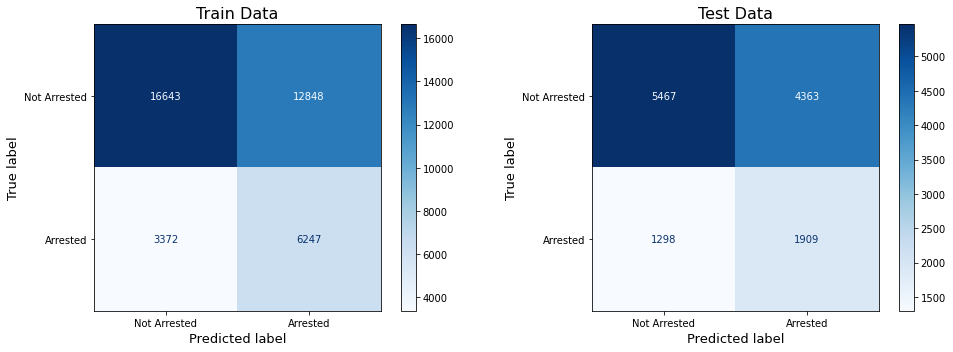

Train Data:                                 Test Data:
Accuracy:  0.5852723088724111               Accuracy:  0.5657743345861778
Recall:    0.649443809127768                Recall:    0.59526036794512
Precision: 0.32715370515841846              Precision: 0.3043686224489796
F1:        0.4351187574005712               F1:        0.402785103913915

    
    
 Test Data Classification Report:
    
              precision    recall  f1-score   support

Not Arrested       0.81      0.56      0.66      9830
    Arrested       0.30      0.60      0.40      3207

    accuracy                           0.57     13037
   macro avg       0.56      0.58      0.53     13037
weighted avg       0.68      0.57      0.60     13037



In [9]:
clf_scores(arrested_smote_cv, X_train, X_test, y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(arrested_smote_cv, X_test, y_test, score_df, 'arrested_smote_cv')
#score_df.head()

#### Performance: 
# WHATTTTTTTTTTTTTTTTTTT#

### Target: Legal Action Taken (Without Synthetic Data)

In [10]:
#remove other targets
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.drop(['Physical_Arrest', 'Arrested'], axis=1, inplace=True)

#new variables for vizualizations and scoring
neg = 'No Legal Action'
pos = 'Legal Action Taken'

#prepare dataset fir bew target
X= dummies_df.drop('Legal_Action_Taken', axis=1)
y = dummies_df['Legal_Action_Taken']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

#create and fit gridsearch pipeline
legal_cv = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=True, scoring='f1')
legal_cv.fit(X_train, y_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(C=0.01,
                                                            max_iter=1000,
                                                            penalty='l1',
                                                            random_state=42,
                                                            solver='liblinear')],
                          'classifier__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+0...
                                                       n_estimators=1000,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
                                                       scale_pos_weight=None,
                                                       subsample=0.7,
                                                       tree_method=None,
                                                       validate_parameters=None,
                                                       verbosity=None)],
                          'classifier__learning_rate': [0.001, 0.01, 0.1],
                          'classifier__max_depth': [9],
                          'classifier__n_estimators': [10, 100, 1000],
                          'classifier__subsample': [0.7]}],
             scoring='f1', verbose=True)

In [11]:
legal_cv.best_params_

# {'classifier': XGBClassifier()
#  'classifier__learning_rate': 0.001,
#  'classifier__max_depth': 9,
#  'classifier__n_estimators': 100,
#  'classifier__subsample': 0.7}

{'classifier': LogisticRegression(C=0.01, max_iter=1000, penalty='l1', random_state=42,
                    solver='liblinear'),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1'}

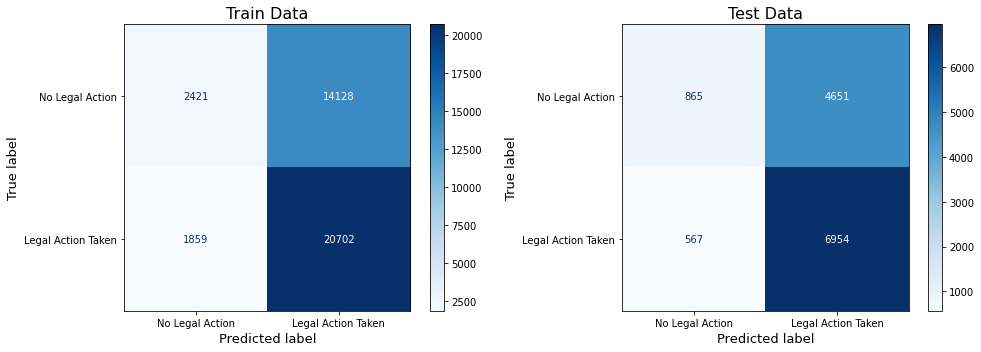

Train Data:                                 Test Data:
Accuracy:  0.5912298644847865               Accuracy:  0.5997545447572294
Recall:    0.9176011701608972               Recall:    0.9246110889509374
Precision: 0.5943726672408843               Precision: 0.5992244722102542
F1:        0.7214371591364499               F1:        0.727177663912998

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

   No Legal Action       0.60      0.16      0.25      5516
Legal Action Taken       0.60      0.92      0.73      7521

          accuracy                           0.60     13037
         macro avg       0.60      0.54      0.49     13037
      weighted avg       0.60      0.60      0.52     13037



In [12]:
clf_scores(legal_cv, X_train, X_test, y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(legal_cv, X_test, y_test, score_df, 'legal_cv')
#score_df.head()

#### Performance: 
# WHATTTTTTTTTTTTTTTTTTT#

### Target: Legal Action Taken (With Synthetic Data)

In [13]:
#fit new gridsearch using pipeline with SMOTE

legal_smote_cv = GridSearchCV(smote_pipeline, params, cv=3, n_jobs=-1, verbose=True, scoring='f1')
legal_smote_cv.fit(X_train, y_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(C=0.01,
                                                            max_iter=1000,
                                                            penalty='l1',
                                                            random_state=42,
                                                            solver='liblinear')],
                          'classifier__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+0...
                                                       n_estimators=1000,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
                                                       scale_pos_weight=None,
                                                       subsample=0.7,
                                                       tree_method=None,
                                                       validate_parameters=None,
                                                       verbosity=None)],
                          'classifier__learning_rate': [0.001, 0.01, 0.1],
                          'classifier__max_depth': [9],
                          'classifier__n_estimators': [10, 100, 1000],
                          'classifier__subsample': [0.7]}],
             scoring='f1', verbose=True)

In [14]:
legal_smote_cv.best_params_

# {'classifier': XGBClassifier()
#  'classifier__learning_rate': 0.01,
#  'classifier__max_depth': 9,
#  'classifier__n_estimators': 1000,
#  'classifier__subsample': 0.7}

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.01, max_delta_step=None, max_depth=9,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=1000, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None),
 'classifier__learning_rate': 0.01,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 1000,
 'classifier__subsample': 0.7}

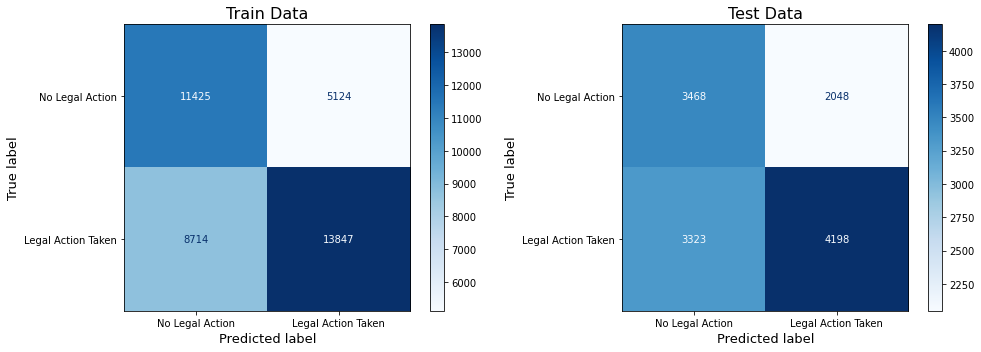

Train Data:                                 Test Data:
Accuracy:  0.6461774482229609               Accuracy:  0.5880187159622613
Recall:    0.6137582553964807               Recall:    0.5581704560563755
Precision: 0.729903536977492                Precision: 0.6721101504963176
F1:        0.6668111335837427               F1:        0.6098641679378224

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

   No Legal Action       0.51      0.63      0.56      5516
Legal Action Taken       0.67      0.56      0.61      7521

          accuracy                           0.59     13037
         macro avg       0.59      0.59      0.59     13037
      weighted avg       0.60      0.59      0.59     13037



In [15]:
clf_scores(legal_smote_cv, X_train, X_test, y_train, y_test, neg, pos)

#save scores for later analysis
score_df = save_scores(legal_smote_cv, X_test, y_test, score_df, 'legal_smote_cv')
#score_df.head()

#### Performance: 
This shows a slight drop in performance metrics from the non-synthetic dataset. This is likely becauase of the fact that the target data in Legal_Action_Taken was significantly less imbalanced, but it also shows us that it is important to check both syntehtic and non-synthetic data when testing new variants of our models.

## Final Model Comparison
Now that we have created quite a few different classification models in our analysis, we can finally look at the results of all of them side by side.

In [ ]:
score_df

In [ ]:
#visualize score_df


## Feature Analysis

The classification models trained with different target variables had significantly different scores, all much better than when the target variable was simply the "Physical Arrest" column.

So far, however, these models have been trained on every single piece of data in the dataset, with the exception of those that we removed in cleaning. There are two issues with this. 

First, some of this data could be meaningless to our classifiers, or even worse, generating noise that can cause our model to underperform or overfit.

Second, there is a limitation on how much real world information we can take away from training models on the entire dataset. If we want to test the predictions of a model based on Subject demographcis alone, for example, then we would want to remove the demographics for the Officer.

### Checking least important features

Next we want see what features could be generating noise in the data, using Lasso Regression to indicate which features have the lowest coefficients.

<AxesSubplot:>

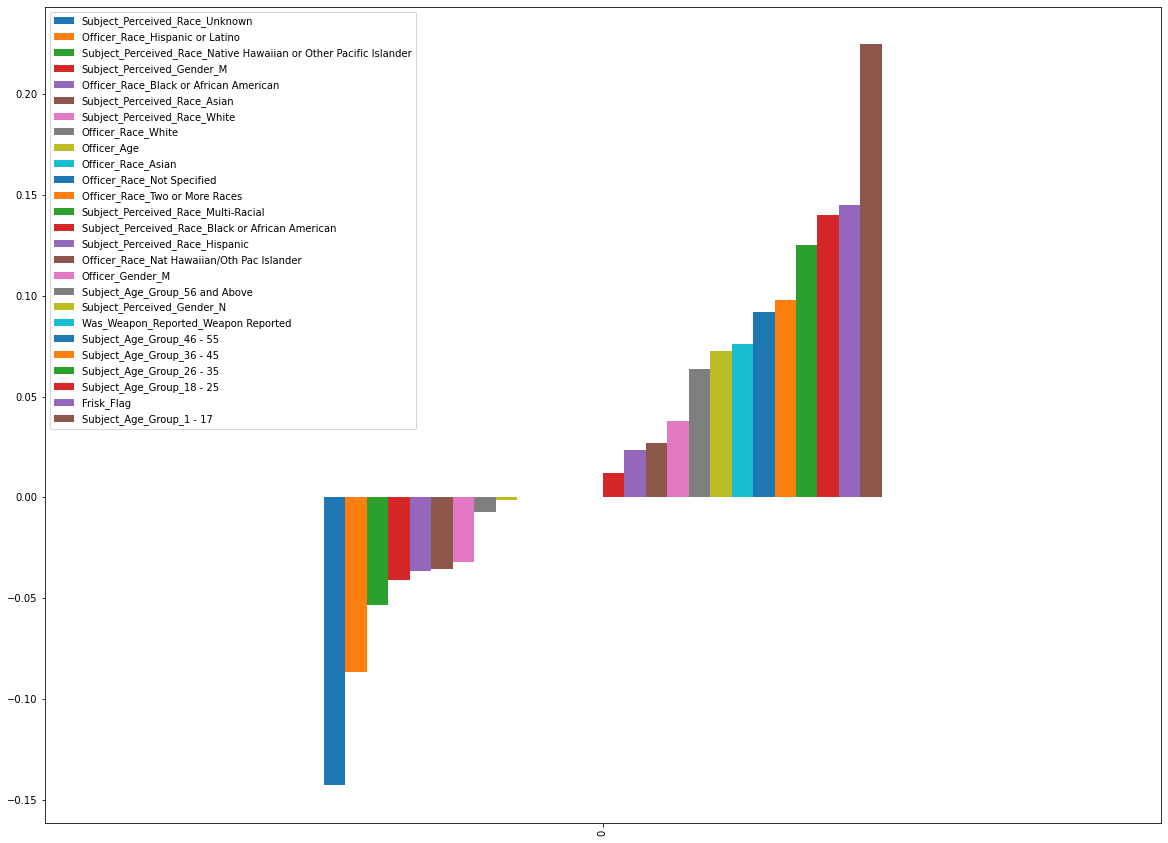

In [17]:
#using most recent featureset (no changes to df, X, or y needed)

#create and fit Lasso Regression model
lasso = Lasso(alpha = 0.0001, normalize = False)
lasso = lasso.fit(X_train, y_train)

#lass model prediction on train data
lasso_pred = lasso.predict(X_train)

#take transpose of lasso coefficients
lasso_coef = pd.DataFrame(data=lasso.coef_).T

#rename columns to match features, sort
lasso_coef.columns = X_train.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T

#bar plot of features by importance
lasso_coef.plot(kind='bar', legend=True, figsize=(20,15))

In [18]:
#list of features by importance
lasso_coef.T

,0
Subject_Perceived_Race_Unknown,-0.142848
Officer_Race_Hispanic or Latino,-0.086521
Subject_Perceived_Race_Native Hawaiian or Other Pacific Islander,-0.053443
Subject_Perceived_Gender_M,-0.041095
Officer_Race_Black or African American,-0.036739
Subject_Perceived_Race_Asian,-0.035310
Subject_Perceived_Race_White,-0.032013
Officer_Race_White,-0.007150
Officer_Age,-0.001085
Officer_Race_Asian,0.000000


We can see by this visualization that specific features are far more impactful on the target, such as "Subject_Age_Group_1 - 17	", and "Subject_Perceived_Race_Unknown".

All the features that have been reduced to 0 have been selected by Lasso as the least significant to the dataset. We will attempt running the model again to see if there is a change in scores.

In [19]:
#show features that became 0 using Lasso
zero_features = lasso_coef.T.index[lasso_coef.T[0] == 0]
zero_features

Index(['Officer_Race_Asian', 'Officer_Race_Not Specified',
       'Officer_Race_Two or More Races',
       'Subject_Perceived_Race_Multi-Racial'],
      dtype='object')

In [20]:
#remove zeroed features from features
X_train.drop(zero_features, axis=1, inplace=True)
X_test.drop(zero_features, axis=1, inplace=True)

In [23]:
#reduced features classifier using best_params from earlier
best = legal_cv.best_estimator_

best.fit(X_train, y_train)

Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

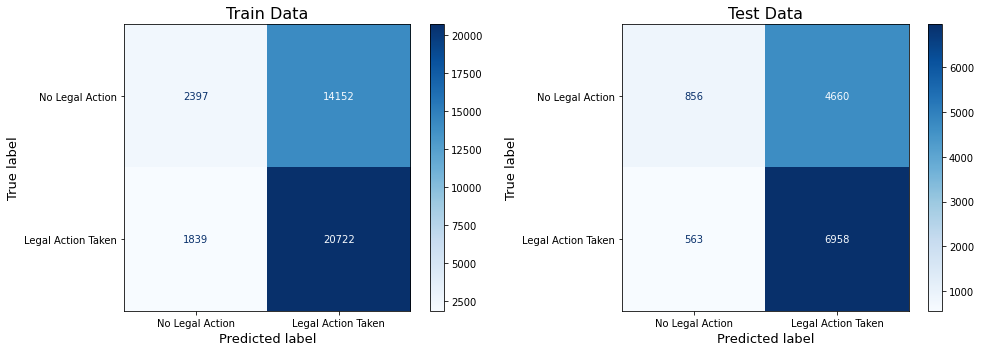

Train Data:                                 Test Data:
Accuracy:  0.591127588851956                Accuracy:  0.5993710209404004
Recall:    0.9184876556890209               Recall:    0.9251429331205957
Precision: 0.5941962493548202               Precision: 0.5988982613186434
F1:        0.7215809175589797               F1:        0.7271017294529495

    
    
 Test Data Classification Report:
    
                    precision    recall  f1-score   support

   No Legal Action       0.60      0.16      0.25      5516
Legal Action Taken       0.60      0.93      0.73      7521

          accuracy                           0.60     13037
         macro avg       0.60      0.54      0.49     13037
      weighted avg       0.60      0.60      0.52     13037



In [24]:
clf_scores(best, X_train, X_test, y_train, y_test, neg, pos)

### Explanation of Results

The fact that we did not get any improvement in our model, and in fact caused f1 scores to go down by a small margin, proves that the extraneous data was not causing any issue for our classifier. This one again points to the issue being caused by the data itself.

At the very least, we can compare the scores from all of the models we have made so far:

In [ ]:
#save all scores from this notebook


In [ ]:
# rerun original logreg baseline models from previous notebook
#logreg
#logreg smote

#


#save scores in SOMETHING

#make barplot comparing classifiers
    #one with just f1?
    #hue = classifier? or hue = score?
        #if so, make f1 score green while the rest are faded or gray
        

In [ ]:
plt.style.use('seaborn-deep')
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data = df, 
             x = "Subject_Perceived_Race", 
             hue = "Legal_Action_Taken", 
             multiple='dodge', bins='auto')

ax.set_xlabel('', fontsize=10)
ax.set_title('Total Stops and Legal Action Taken by Subject Race', fontsize=17)
plt.legend(labels=['Arrested', 'Stopped'], fontsize=14)
plt.xticks(rotation= 33, ha='right', rotation_mode='anchor', fontsize=12)

Unfortunately, with the current data, it seems unlikely to help our models perform any better with a binary target. This is most likely due to the variability and lack of clarity in very much of the original data. There is clearly potential for more accurate classifiers, but only with more specific data, or perhaps different configurations of the original dataset.

Another potential change that could be made is an adjustment to the type of Classifier. A multiclass or multioutput classifier, or even an unsupervised learning algorithm could find different results, potentially identifying key groups of features that yield different targets.

# Conclusion

# Baseline Etc

# Best

# Problems
## stadnardized, detailed data
## single target

# Solutions
## more standardization
## multi target
## separate analysis of performance per officer based on past records

As is clear from these tests (and as stated above), there are a vast assortment of possibilities that can be investigated in future analyses. The limitations of a binary target classification algorithm make it challenging to adequately find the results we need to make any sort of substantive reports about the data we have, besides the fact that we need more detailed and standardized data.